In [84]:
import torch
from typing import List, Callable, Any, Tuple
import torchdata
import torchtext

In [85]:
N = 20010
n = 10

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [140]:
from zipfile import ZipFile


with ZipFile('../../data/1mcorpus.zip', 'r') as zipfile:
    with zipfile.open('1mcorpus/corpus.en_ru.1m.en', 'r') as eng:
        eng_text = list(map(lambda b: b.decode(), eng.readlines()[:N]))
    with zipfile.open('1mcorpus/corpus.en_ru.1m.ru', 'r') as ru:
        ru_text = list(map(lambda b: b.decode(), ru.readlines()[:N]))

In [141]:
for_predict_ru = ru_text[N-n:N]
for_predict_eng = eng_text[N-n:N]

In [142]:
len(for_predict_ru), len(for_predict_eng)

(10, 10)

In [90]:
from torchdata import datapipes


ru_text = datapipes.iter.IterableWrapper(ru_text[:N-n])
eng_text = datapipes.iter.IterableWrapper(eng_text[:N-n])
len(ru_text), len(eng_text)

(20000, 20000)

In [91]:
def preprocessing(text_document: str | List[str], pipeline: List[Callable]) -> Any:
    temp = text_document
    for command in pipeline:
        temp = command(temp)
    return temp

In [92]:
def yield_tokens(data_iter: torchdata.datapipes.iter.IterDataPipe, pipeline: List[Callable]):
    for text in data_iter:
        yield preprocessing(text, pipeline)

In [93]:
from razdel import tokenize


PIPELINE = [
    lambda s: [token.text for token in list(tokenize(s.strip())) if token.text if not token.text.isdigit()]
]

In [94]:
from torchtext.vocab import build_vocab_from_iterator


ru_vocab = build_vocab_from_iterator(
    yield_tokens(ru_text, pipeline=PIPELINE),
    min_freq=1,
    specials=['<PAD>', '<SOS>', '<EOS>', '<UNK>'],
    special_first=True
)
ru_vocab.set_default_index(ru_vocab['<UNK>'])

In [173]:
ru_vocab.get_stoi()

{'ИРЭ': 34265,
 'построить': 4248,
 'полагает': 5926,
 'удивляться': 68911,
 'веб-страницу': 20200,
 'грузовиков': 46006,
 'обладающих': 15431,
 'деятельности': 157,
 'рецепторами': 64353,
 'из-за': 295,
 'появление': 7974,
 'трое': 12699,
 'судьей': 26688,
 'дней': 320,
 'Today': 30771,
 'будет': 46,
 'язвы': 27833,
 'достигал': 14410,
 'резонанс': 25854,
 'Джордж': 18427,
 'экономические': 1915,
 'инженеров': 9062,
 'обозначать': 23496,
 '<EOS>': 2,
 'CDRoller': 28909,
 'малейшую': 52385,
 'нарушениями': 3511,
 'Steven': 17948,
 'влиянием': 2744,
 'основополагающее': 56855,
 'стать': 457,
 'пережитых': 58146,
 'телекоммуникаций': 17054,
 '/': 64,
 'Отделенный': 37055,
 'COM': 10226,
 'Trevrizent': 30793,
 'век': 2546,
 'Вакарчука': 32601,
 'на': 8,
 'ежедневными': 47398,
 '<PAD>': 0,
 'забирает': 47666,
 'Задолго': 34071,
 'грозах': 45968,
 'привычным': 25137,
 'междунан': 52700,
 'связям': 16649,
 'предела': 9629,
 'том': 56,
 'нашем': 1540,
 'ярко-зеленая': 71731,
 'женский': 8980,

In [96]:
eng_vocab = build_vocab_from_iterator(
    yield_tokens(eng_text, pipeline=PIPELINE),
    min_freq=1,
    specials=['<PAD>', '<SOS>', '<EOS>', '<UNK>'],
    special_first=True
)
eng_vocab.set_default_index(eng_vocab['<UNK>'])

In [174]:
eng_vocab.get_stoi()

{'clearing': 14259,
 'reasons': 1038,
 'Wear': 26125,
 'adapted': 5645,
 'mood': 5927,
 'probably': 968,
 'customers': 1047,
 'in': 10,
 'blogging': 10382,
 'counterpart': 14423,
 'hues': 30560,
 'geographic': 7463,
 'default': 1668,
 'attentions': 26989,
 'reversing': 11524,
 '<EOS>': 2,
 'invasion': 3625,
 'COM': 7970,
 'droves': 28991,
 '/': 85,
 'ESCWA': 9688,
 'monitors': 8995,
 '122.8': 17103,
 'stars': 3127,
 'Komintern': 21898,
 'quiesce': 33504,
 'depicting': 28645,
 'participation': 919,
 'capitalism': 3554,
 'adhered': 26519,
 'surveyed': 5436,
 'injunction': 30916,
 'ultimate': 11802,
 'If': 107,
 'Kulov': 12871,
 'draught': 28964,
 'shorter': 16387,
 '<PAD>': 0,
 'cactus': 27570,
 'helping': 1874,
 'SARS': 10067,
 'an': 38,
 'operation': 775,
 'individual': 440,
 'compact': 4086,
 '2000-2006': 17271,
 'editions': 29093,
 'modeling': 31959,
 'enact': 29209,
 'freedoms': 4147,
 'seeks': 3948,
 'earth-bound': 29057,
 'York': 1716,
 'conversation': 3046,
 'grudges': 30202,
 'r

In [98]:
from torchtext import transforms


def vocab_transform(vocab: torchtext.vocab.Vocab) -> transforms.Sequential:
    text_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
        transforms.AddToken(vocab['<SOS>'], begin=True),
        transforms.AddToken(vocab['<EOS>'], begin=False)
    )
    return text_transform


def apply_ru_vocab_transform(text: str) -> List[str]:
    return vocab_transform(ru_vocab)(preprocessing(text, PIPELINE))

def apply_eng_vocab_transform(text: str):
    return vocab_transform(eng_vocab)(preprocessing(text, PIPELINE))

In [99]:
ru_text_id = ru_text.map(apply_ru_vocab_transform)
eng_text_id = eng_text.map(apply_eng_vocab_transform)

In [100]:
ru_eng_text_id = ru_text_id.zip(eng_text_id)

In [101]:
ru_eng_text_id = ru_eng_text_id.bucketbatch(
    batch_size = 200,
    use_in_batch_shuffle=False,  
)

In [102]:
def apply_separate(pair: List[Tuple[List[int], List[int]]]) -> List[Tuple[Tuple[List[int],], Tuple[List[int],]]]:
    source, target = zip(*pair)
    return source, target

In [103]:
ru_eng_text_id = ru_eng_text_id.map(apply_separate)

In [104]:
def apply_padding(pair: List[Tuple[Tuple[List[int],], Tuple[List[int],]]]) -> Tuple[torch.Tensor, torch.Tensor]:
    return (
        transforms.ToTensor(ru_vocab['<PAD>'])(list(pair[0])).to(device),
        transforms.ToTensor(eng_vocab['<PAD>'])(list(pair[1])).to(device)
    )

In [105]:
ru_eng_text_id = ru_eng_text_id.map(apply_padding)

## Encoder

In [106]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, source_vocab_size: int, input_size: int, hidden_size: int, device: torch.DeviceObjType) -> None:
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=source_vocab_size, embedding_dim=input_size, device=device)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, device=device, batch_first=True)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        x: [batch_size x seq_size]
        -----------------------
        out: [batch_size x seq_size x hidden_size]
        h: [1 x batch_size x hidden_size]
        """
        out, h = self.gru(self.embedding(x))
        return out, h

## Decoder

In [107]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size: int, input_size: int, hidden_size: int, device: torch.DeviceObjType) -> None:
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=input_size, device=device)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, device=device, batch_first=True)
        self.linear = nn.Linear(in_features=2*hidden_size, out_features=target_vocab_size, device=device)
        self.softmax = nn.Softmax(1)

    def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, h_0: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        x: [batch_size, 1]
        encoder_out: [batch_size x seq_size x hidden_size]
        h_0: [1 x batch_size x hidden_size]
        -----------------------
        y: [batch_size х 1]
        h_1: [1 x batch_size x hidden_size]
        """
        _, h_1 = self.gru(self.embedding(x), h_0)
        a = self.attention(h_1.squeeze(0), encoder_out)
        hs = torch.cat((h_1.squeeze(0), a), 1)
        l = self.linear(hs)
        y = torch.argmax(self.softmax(l), axis=1, keepdim=True)
        return y, h_1

    def attention(self, h: torch.Tensor, encoder_out: torch.Tensor) -> torch.Tensor:
        """
        h: [batch_size x hidden_size]
        encoder_out: [batch_size x seq_size x hidden_size]
        -----------------------
        a: [batch_size x hidden_size]
        """
        dot_products = torch.sum(encoder_out * h.unsqueeze(1), axis=2)
        probabilities = self.softmax(dot_products)
        return torch.sum(encoder_out * probabilities.unsqueeze(2), axis=1)

## Seq2Seq

In [108]:
import random


class NMT(nn.Module):
    def __init__(self, source_vocab: torchtext.vocab.Vocab, target_vocab: torchtext.vocab.Vocab, input_size: int, hidden_size: int, device: torch.DeviceObjType) -> None:
        super(NMT, self).__init__()
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

        # self.sos_id = target_vocab['<SOS>']

        self.encoder = Encoder(source_vocab_size=len(source_vocab), input_size=input_size, hidden_size=hidden_size, device=device)
        self.decoder = Decoder(target_vocab_size=len(target_vocab), input_size=input_size, hidden_size=hidden_size, device=device)
        
    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing: float = 0.6) -> torch.Tensor:
        """
        x: [batch_size x source_seq_len]
        y: [batch_size x target_seq_len]
        -----------------------
        outputs: [batch_size x target_seq_len]
        """
        batch_size, target_seq_len = y.shape
        outputs = torch.zeros(batch_size, 1, device=device, requires_grad=True)
        encoder_out, h = self.encoder(x)
        input = y[:, 0].reshape(-1, 1)
        for i in range(1, target_seq_len):
            output, h = self.decoder(input, encoder_out, h)
            outputs = torch.hstack((outputs, output))
            input = y[:, i].reshape(-1, 1) if teacher_forcing > random.random() else output
        return outputs

## Обучение модели

In [109]:
INPUT_SIZE = 32
HIDDEN_SIZE = 40

In [110]:
model = NMT(ru_vocab, eng_vocab, INPUT_SIZE, HIDDEN_SIZE, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)
loss_function = nn.CrossEntropyLoss()

In [111]:
history = []
epochs = 30
for epoch in range(epochs):
    for x_b, y_b in ru_eng_text_id:
        output = model(x_b, y_b)
        loss_value = loss_function(output[:, 1:], y_b[:, 1:].to(torch.float32))
        history.append(loss_value.item())
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()  
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 796199168.0
Эпоха 2, Значение функции потерь: 771918528.0
Эпоха 3, Значение функции потерь: 744935808.0
Эпоха 4, Значение функции потерь: 833765952.0
Эпоха 5, Значение функции потерь: 876453312.0
Эпоха 6, Значение функции потерь: 808716608.0
Эпоха 7, Значение функции потерь: 799930496.0
Эпоха 8, Значение функции потерь: 841661888.0
Эпоха 9, Значение функции потерь: 850880000.0
Эпоха 10, Значение функции потерь: 842325184.0
Эпоха 11, Значение функции потерь: 886394176.0
Эпоха 12, Значение функции потерь: 816738304.0
Эпоха 13, Значение функции потерь: 890771520.0
Эпоха 14, Значение функции потерь: 778677824.0
Эпоха 15, Значение функции потерь: 848764032.0
Эпоха 16, Значение функции потерь: 810468800.0
Эпоха 17, Значение функции потерь: 789605632.0
Эпоха 18, Значение функции потерь: 782543104.0
Эпоха 19, Значение функции потерь: 827213120.0
Эпоха 20, Значение функции потерь: 846107264.0
Эпоха 21, Значение функции потерь: 892703360.0
Эпоха 22, Значение фун

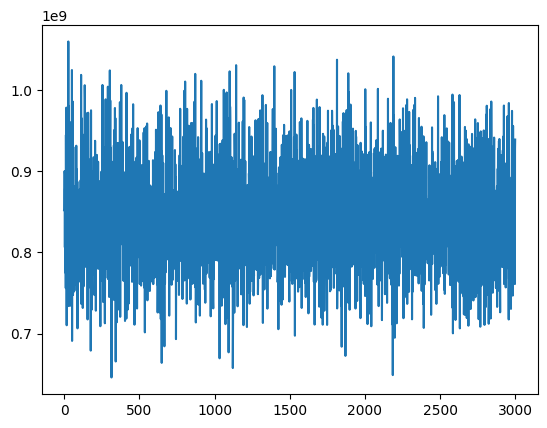

In [112]:
import matplotlib.pyplot as plt


plt.plot(history)

## Получение предсказания

In [145]:
fpr = datapipes.iter.IterableWrapper(for_predict_ru)

In [146]:
fpr = fpr.map(apply_ru_vocab_transform)

In [148]:
def apply_padding_predict(doc: List[List[int]]) -> torch.Tensor:
    return transforms.ToTensor(ru_vocab['<PAD>'])(doc).to(device)

In [150]:
fpr = fpr.map(apply_padding_predict)

In [156]:
X_test = torch.nn.utils.rnn.pad_sequence(fpr, padding_value=0).T.to(device)

In [164]:
y_test = model(X_test, torch.zeros(n, 20, dtype=torch.int64).to(device), 0)[:, 1:]

In [172]:
for ru, pred, eng in zip(for_predict_ru, y_test, for_predict_eng):
    s = ' '.join([eng_vocab.lookup_token(id) for id in pred])
    print(f"Фраза на русском:\n{ru}\nФраза на английском:\n{eng}\nПредсказание:\n{s}\n------------------------------------------------------")

Фраза на русском:
Ответ на этот вопрос мы получим после объявленного в этом году слияния двух шведских банков - Swedbank и Skandinavska Enskilda Banken (SEB), владеющих крупнейшими банками в Балтии.

Фраза на английском:
It seems we'll get the answer to this question after a merger of two top Swedish banks, announced earlier this year.

Предсказание:
praised unwind reinstalling Trainers Rinkevics modules exact mediums SIGN SIGN SIGN SIGN SIGN SIGN SIGN SIGN SIGN SIGN SIGN
------------------------------------------------------
Фраза на русском:
В Эстонии активы Hansapank и Uhispank составляют почти 90% всех отраслевых активов.

Фраза на английском:
In Estonia Hansapank and Uhispank account for nearly 90 percent of the banking sector's total assets.

Предсказание:
praised unwind reinstalling Trainers unwind Orb incrimination legislates legislates FINANCING praised unwind informed Orb incrimination praised unwind Orb incrimination
------------------------------------------------------
Фра